# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).

**Heavily edited by blackle mori. click on the link above for the original paper and colab notebook**


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [5]:
from math import sqrt
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, has_skip=False, skip_idx=1):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.has_skip = has_skip
        self.skip_idx = skip_idx
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1. / self.in_features, 
                                             1. / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        intermediate = torch.sin(self.omega_0 * self.linear(input))
        if self.has_skip:
            intermediate = intermediate/self.skip_idx + input
        return intermediate
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 omega=30, first_linear=False):
        super().__init__()
        self.omega = omega
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_layers = hidden_layers
        self.hidden_features = hidden_features
        self.first_linear=first_linear
        self.net = []
        if first_linear:
            linear = nn.Linear(in_features, hidden_features)
            with torch.no_grad():
                linear.weight.uniform_(-1. / self.in_features / omega, 
                                        1. / self.in_features / omega) 
            self.net.append(linear)
        else:
            self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=omega))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=omega, has_skip=True, skip_idx=sqrt(i+1)))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / omega, 
                                              np.sqrt(6 / hidden_features) / omega)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=omega))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [6]:
from skimage import io
def get_image_tensor(sidelength, filename):
    img = Image.fromarray(skimage.io.imread(filename, as_gray=True))        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

In [7]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, filename):
        super().__init__()
        img = get_image_tensor(sidelength, filename)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [127]:
cat = ImageFitting(256, "cat.jpg")
catloader = DataLoader(cat, batch_size=1, pin_memory=True, num_workers=0)
catfocus = ImageFitting(256, "catfocus.jpg")
focusloader = DataLoader(catfocus, batch_size=1, pin_memory=True, num_workers=0)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [128]:
import re

def dump_data(dat):
  dat = dat.cpu().detach().numpy()
  return dat

def print_vec4(ws):
  vec = "vec4(" + ",".join(["{0:.2f}".format(w) for w in ws]) + ")"
  vec = re.sub(r"\b0\.", ".", vec)
  return vec

def print_mat4(ws):
  mat = "mat4(" + ",".join(["{0:.2f}".format(w) for w in np.transpose(ws).flatten()]) + ")"
  mat = re.sub(r"\b0\.", ".", mat)
  return mat

def serialize_to_shadertoy(siren, varname):
  #first layer
  omega = siren.omega
  chunks = int(siren.hidden_features/4)
  lin = siren.net[0] if siren.first_linear else siren.net[0].linear
  in_w = dump_data(lin.weight)
  in_bias = dump_data(lin.bias)
  om = 1 if siren.first_linear else omega
  for row in range(chunks):
    if siren.first_linear:
        line = "vec4 %s1_%d, %s0_%d=(" % (varname, row, varname, row)
    else:
        line = "vec4 %s1_%d, %s0_%d=sin(" % (varname, row, varname, row)

    for ft in range(siren.in_features):
        feature = x_vec = in_w[row*4:(row+1)*4,ft]*om
        line += ("ft_%d*" % ft) + print_vec4(feature) + "+"
    bias = in_bias[row*4:(row+1)*4]*om
    line += print_vec4(bias) + ");"
    print(line)

  #hidden layers
  for layer in range(siren.hidden_layers):
    layer_w = dump_data(siren.net[layer+1].linear.weight)
    layer_bias = dump_data(siren.net[layer+1].linear.bias)
    for row in range(chunks):
      line = ("%s%d_%d" % (varname, (layer+1)%2, row)) + "=sin("
      for col in range(chunks):
        mat = layer_w[row*4:(row+1)*4,col*4:(col+1)*4]*omega
        line += print_mat4(mat) + ("*%s%d_%d"%(varname, layer%2, col)) + "+\n    "
      bias = layer_bias[row*4:(row+1)*4]*omega
      line += print_vec4(bias)+")/%0.1f+%s%d_%d;"%(sqrt(layer+1), varname, layer%2, row)
      print(line)

  #output layer
  out_w = dump_data(siren.net[-1].weight)
  out_bias = dump_data(siren.net[-1].bias)
  for outf in range(siren.out_features):
    line = "float %s_%d=" % (varname, outf)
    for row in range(chunks):
      vec = out_w[outf,row*4:(row+1)*4]
      line += ("dot(%s%d_%d,"%(varname, siren.hidden_layers%2, row)) + print_vec4(vec*.5) + ")+\n    "
    print(line + "{:0.3f}".format(out_bias[outf]*.5+.5)+";")


In [124]:
import pytorch_ssim

def train_siren(dataloader, focusloader, out_features, hidden_features, hidden_layers, omega):
  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
  _, focus = next(iter(dataloader))
  focus = focus.cuda()

  img_curr = Siren(in_features=2, out_features=out_features, hidden_features=hidden_features, 
                   hidden_layers=hidden_layers, outermost_linear=True, omega=omega, first_linear=False)
  img_curr.cuda()
  optim = torch.optim.Adam(lr=1e-3, params=img_curr.parameters(), weight_decay=.01)
  optim2 = torch.optim.Adam(lr=1e-3, params=img_curr.parameters(), weight_decay=.0)
  ssim_loss = pytorch_ssim.SSIM(window_size = 6)
  total_steps = 20000
  update = int(total_steps/50)
  for step in range(total_steps):
    if step == 500:
        optim.param_groups[0]['weight_decay'] = 0
    model_output, coords = img_curr(model_input)
    #loss = (model_output - ground_truth)**4
    loss = (model_output - ground_truth)**2
    #loss = abs(model_output - ground_truth)
    #loss = ((model_output - ground_truth)**2 + abs(model_output - ground_truth))/2
    #loss = loss * (focus*.4+1)
    loss = loss.mean()

    if step < total_steps/2:
        optim.zero_grad()
        loss.backward()
        optim.step()
    else:
        ssim_out = -ssim_loss(model_output.view(256,256)[None, None, :, :], ground_truth.view(256,256)[None, None, :, :])
        optim2.zero_grad()
        ssim_out.backward()
        optim2.step()

    if (step % update) == update-1:
        print("Step %d, Current loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,2, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[1].imshow((model_output - ground_truth).cpu().view(256,256).detach().numpy(), cmap='gray', vmin=-1, vmax=1)
        plt.show()

  return img_curr

First we train the black and white version of the cat

Step 399, Current loss 0.005729


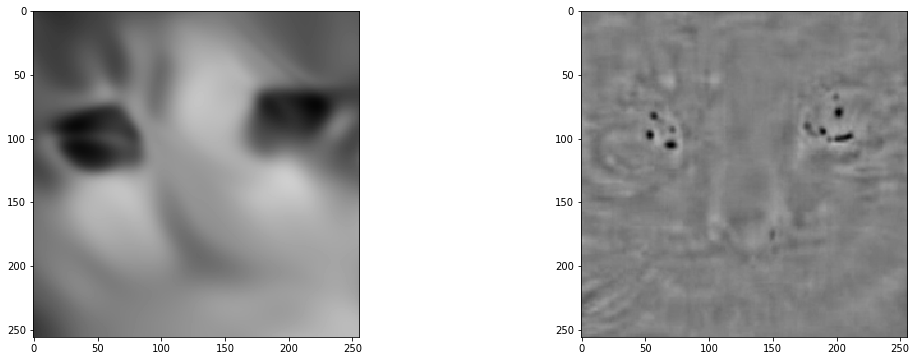

Step 799, Current loss 0.003434


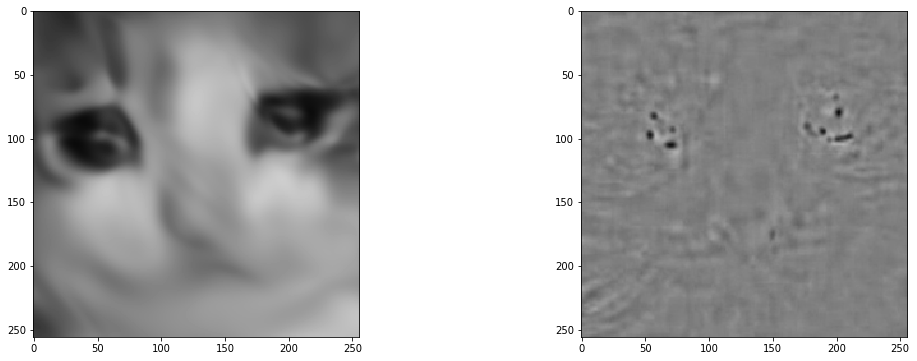

Step 1199, Current loss 0.002379


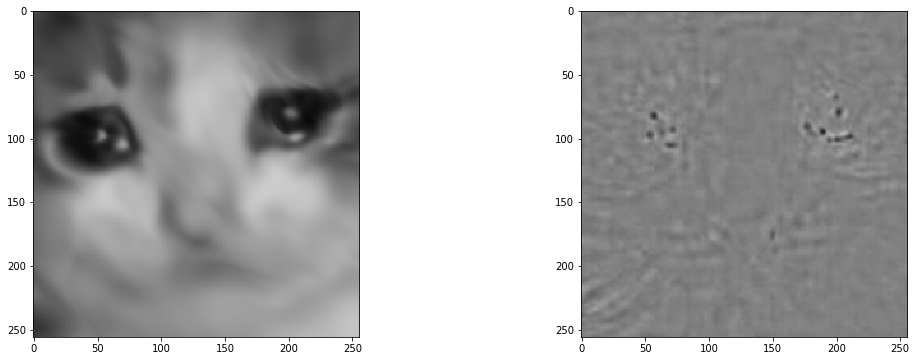

Step 1599, Current loss 0.001910


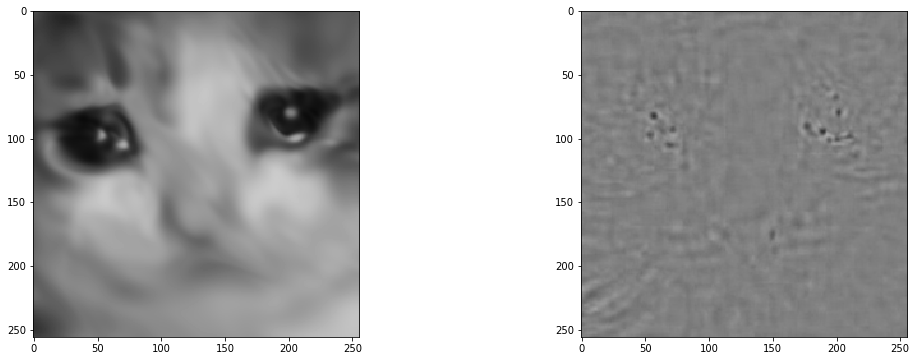

Step 1999, Current loss 0.001750


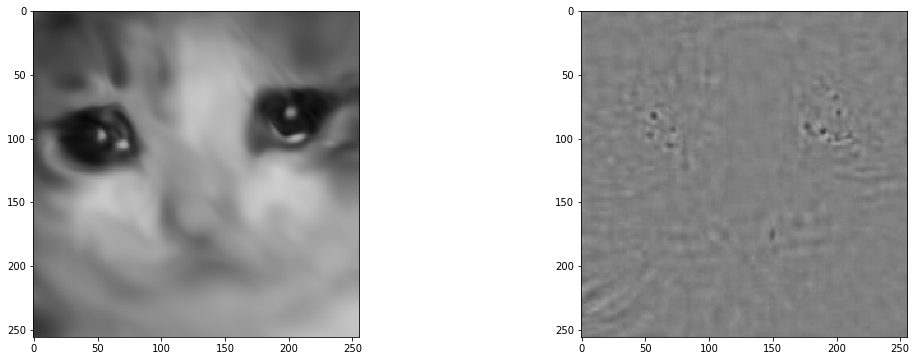

Step 2399, Current loss 0.001643


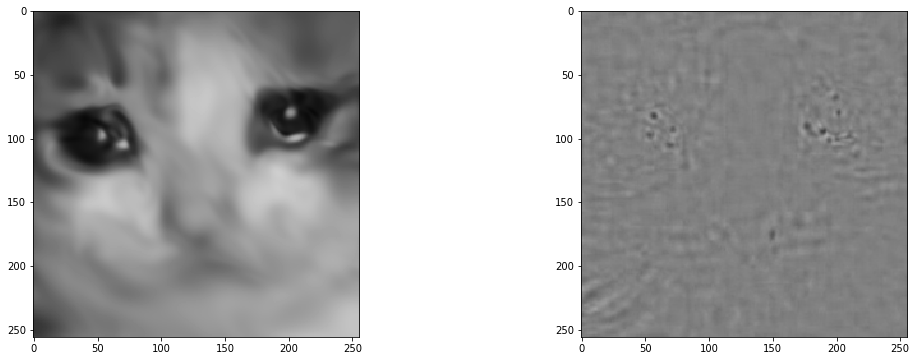

Step 2799, Current loss 0.001599


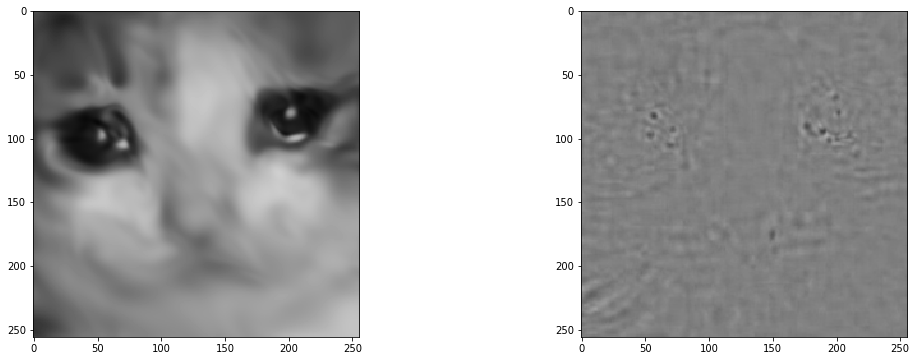

Step 3199, Current loss 0.001545


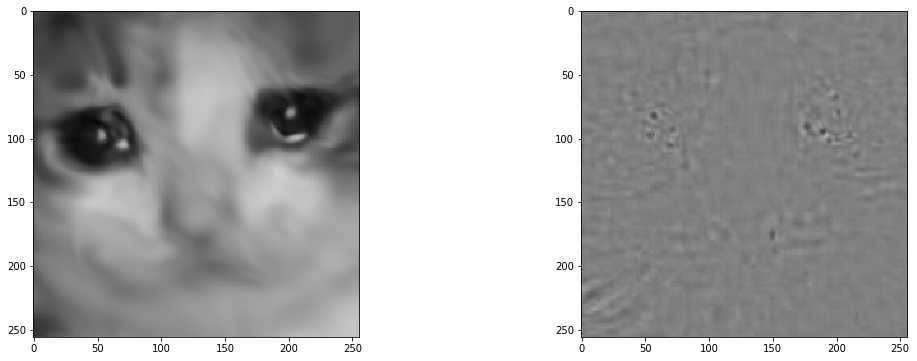

Step 3599, Current loss 0.001518


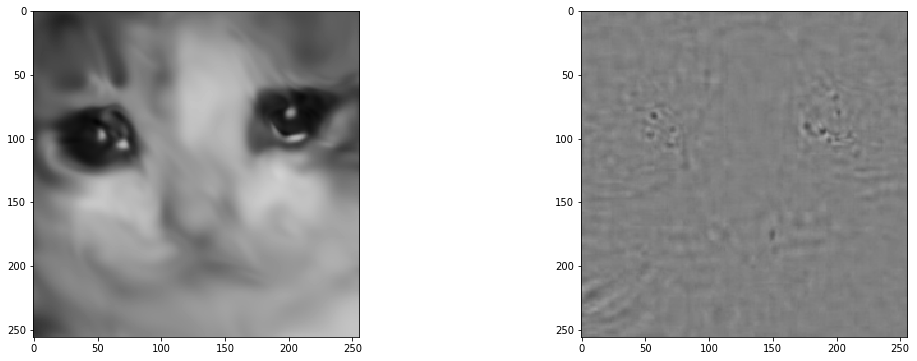

Step 3999, Current loss 0.001500


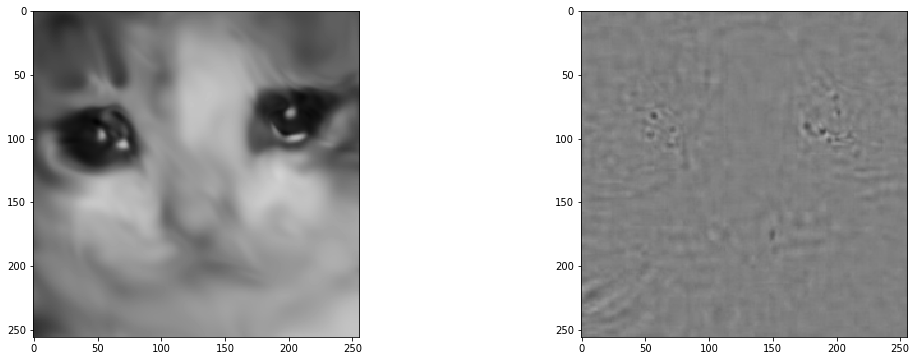

Step 4399, Current loss 0.001474


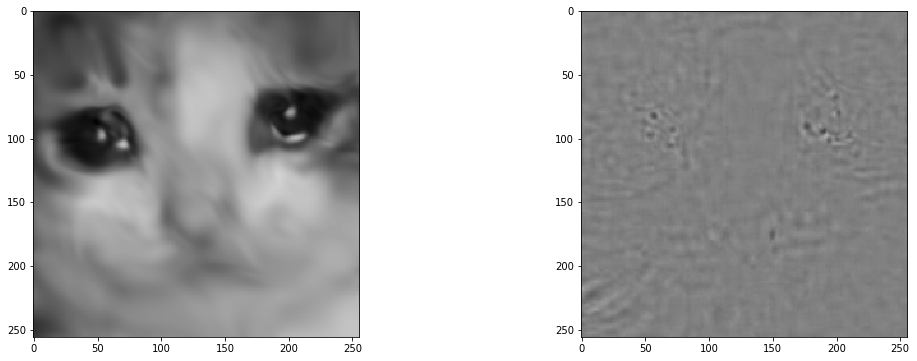

Step 4799, Current loss 0.001432


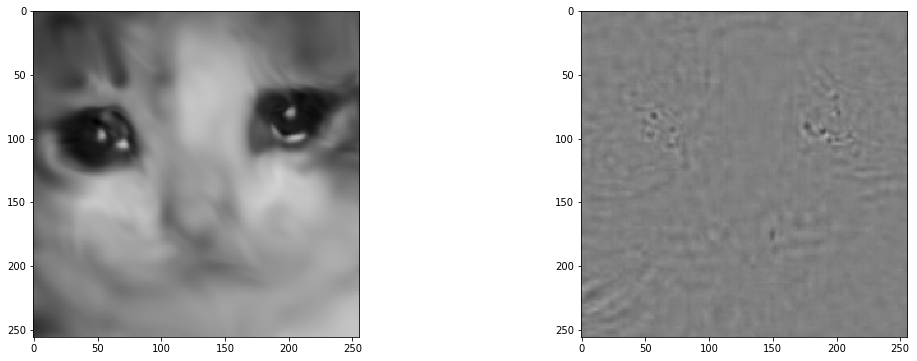

Step 5199, Current loss 0.001435


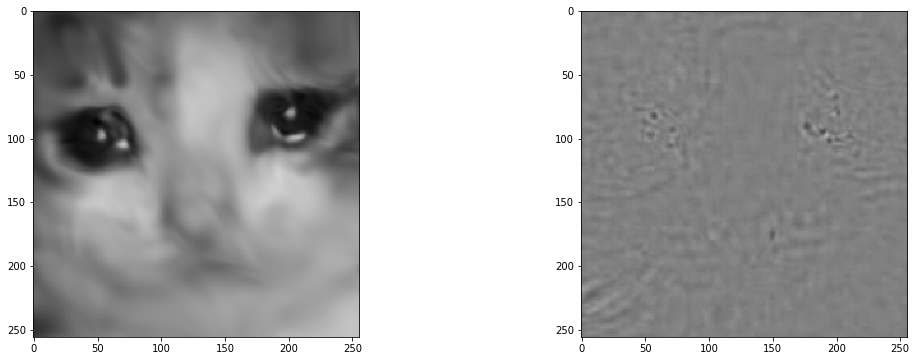

Step 5599, Current loss 0.001441


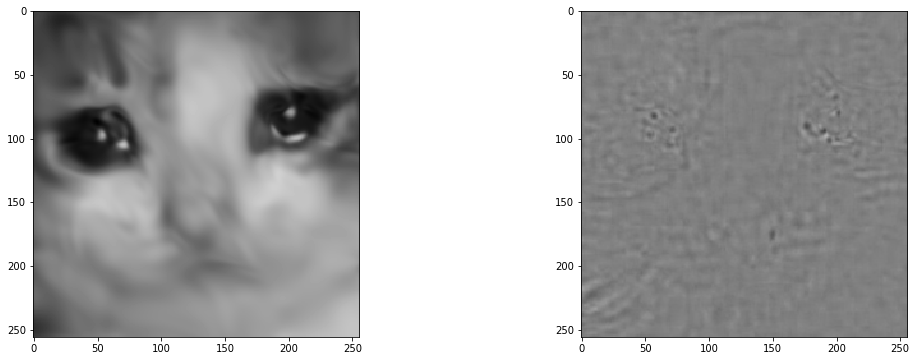

Step 5999, Current loss 0.001370


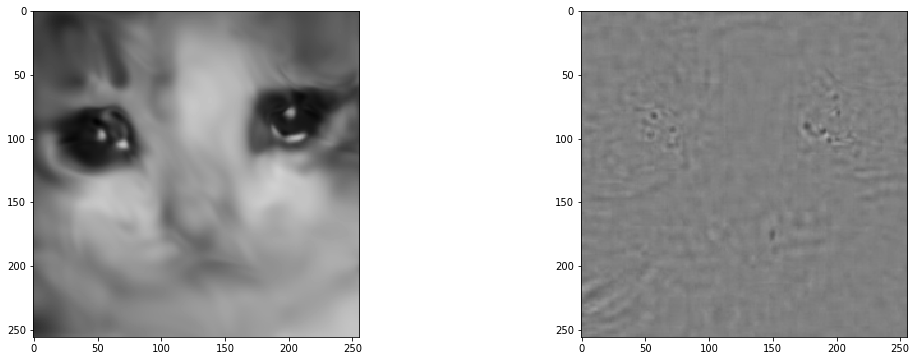

Step 6399, Current loss 0.001359


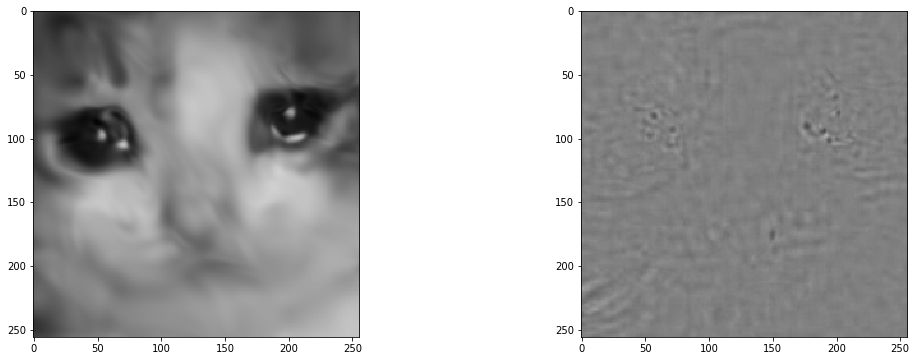

Step 6799, Current loss 0.001353


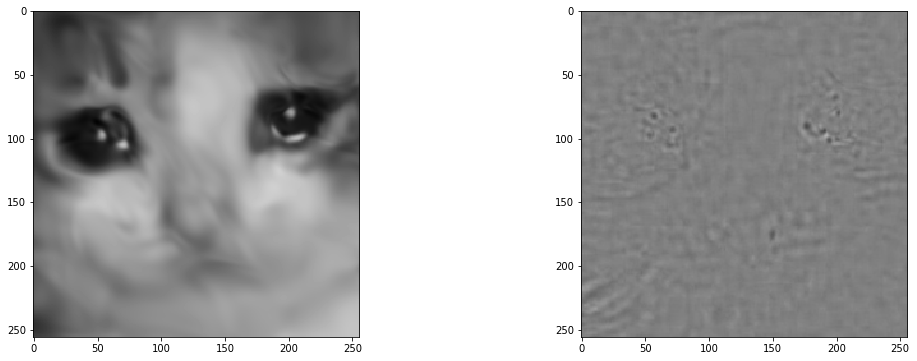

Step 7199, Current loss 0.001362


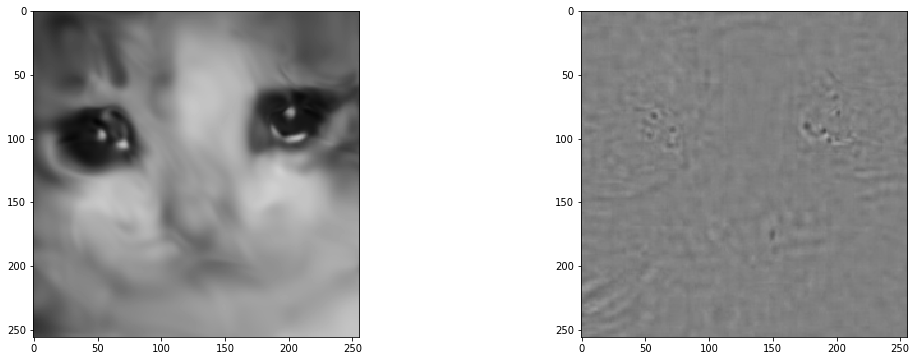

Step 7599, Current loss 0.001296


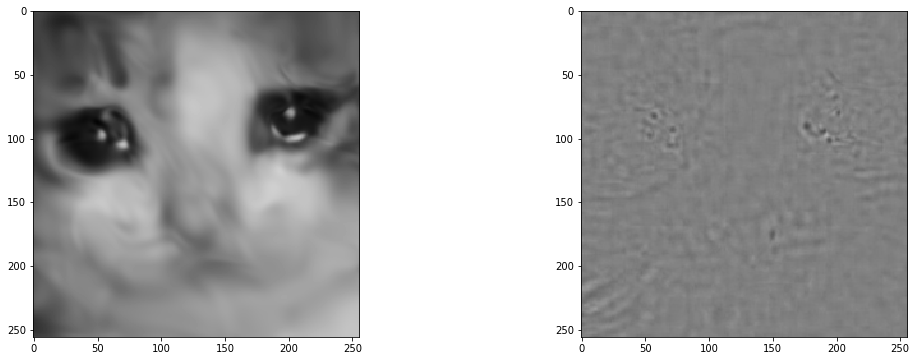

Step 7999, Current loss 0.001339


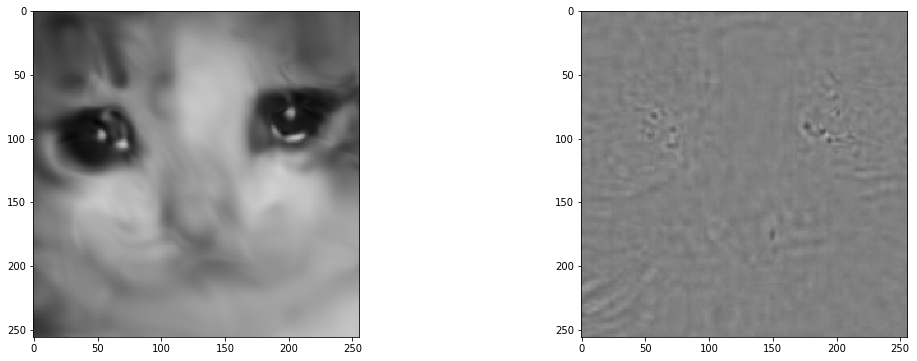

Step 8399, Current loss 0.001342


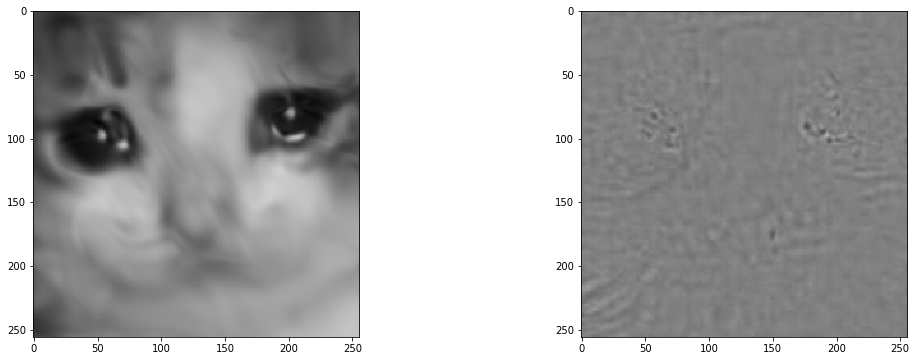

Step 8799, Current loss 0.001286


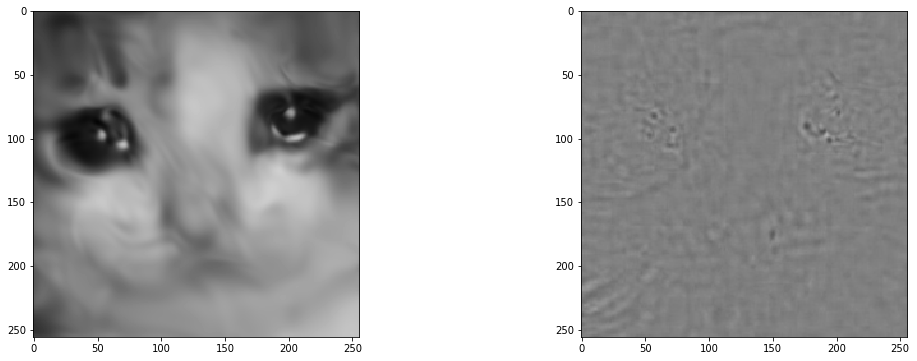

Step 9199, Current loss 0.001254


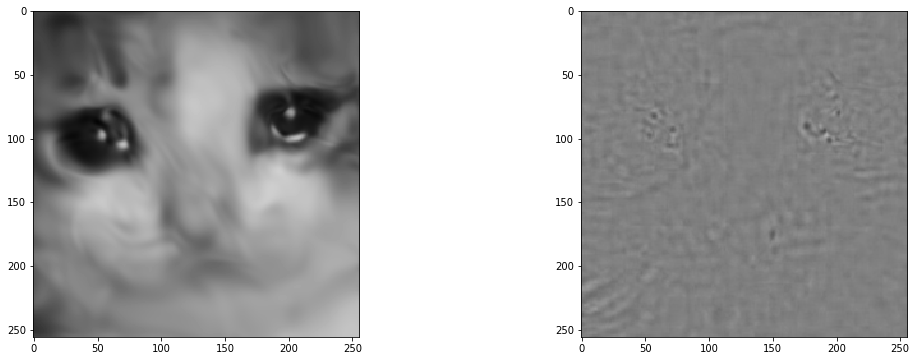

Step 9599, Current loss 0.001264


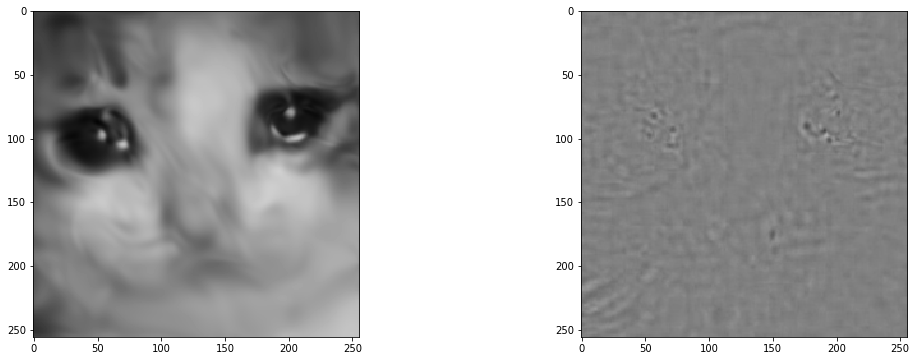

Step 9999, Current loss 0.001279


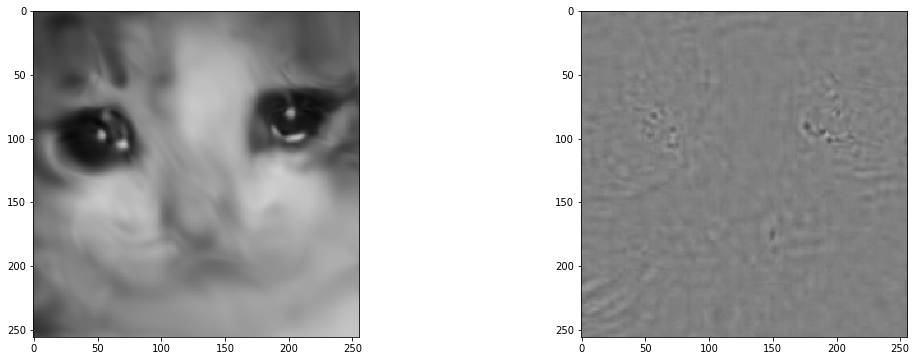

Step 10399, Current loss 0.001615


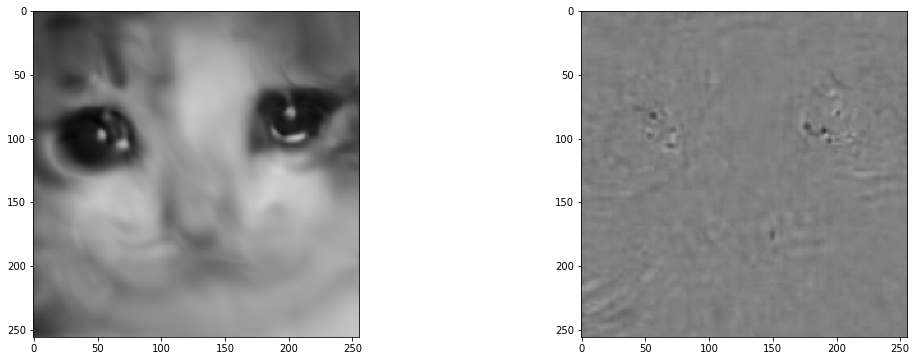

Step 10799, Current loss 0.001664


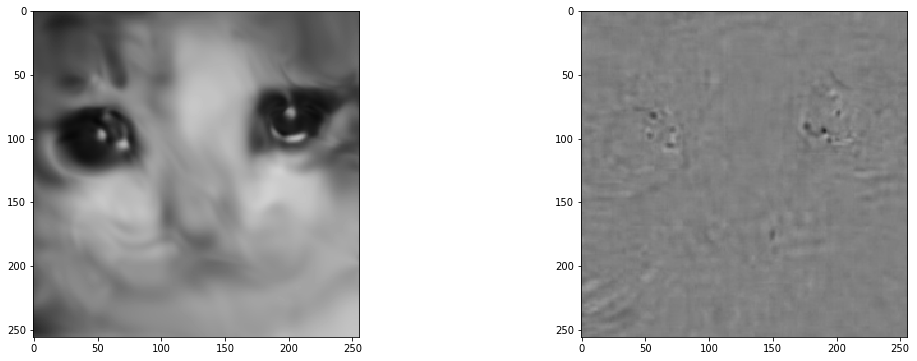

Step 11199, Current loss 0.001723


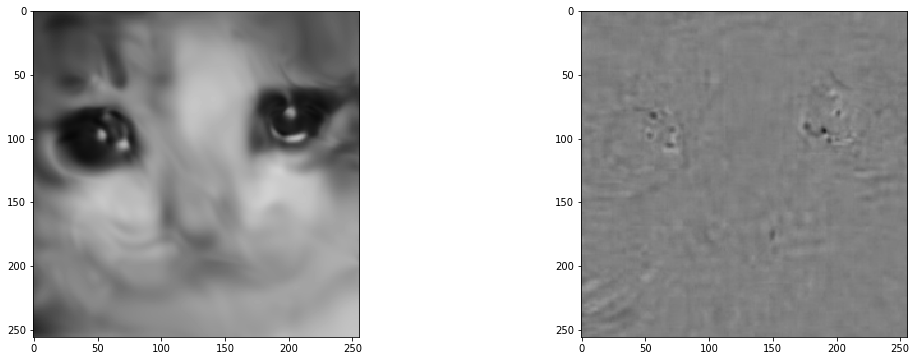

Step 11599, Current loss 0.001716


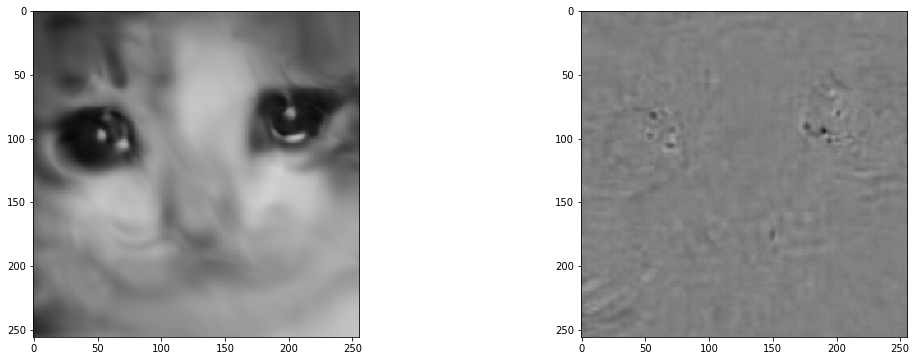

Step 11999, Current loss 0.001769


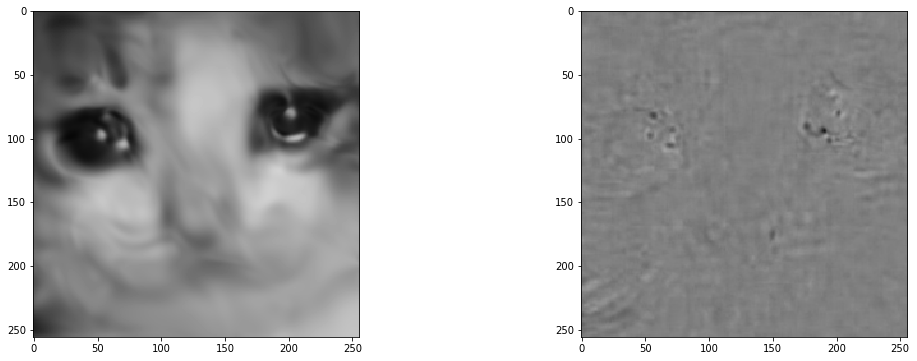

Step 12399, Current loss 0.001756


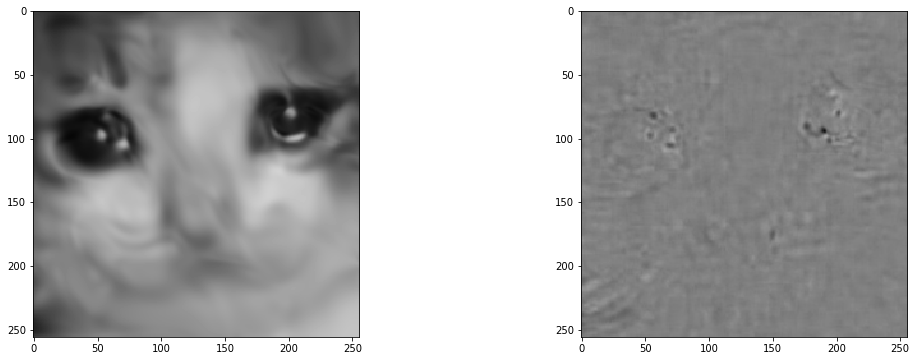

Step 12799, Current loss 0.001816


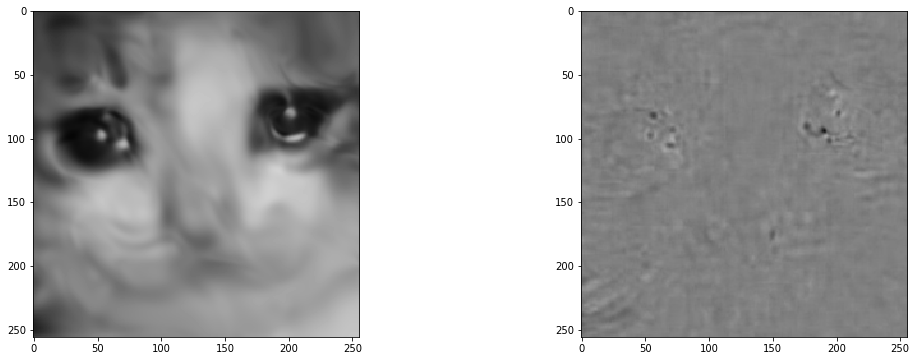

Step 13199, Current loss 0.001815


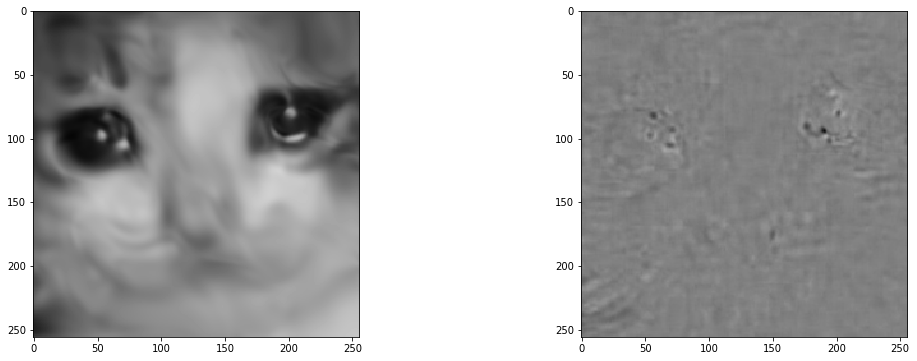

Step 13599, Current loss 0.001805


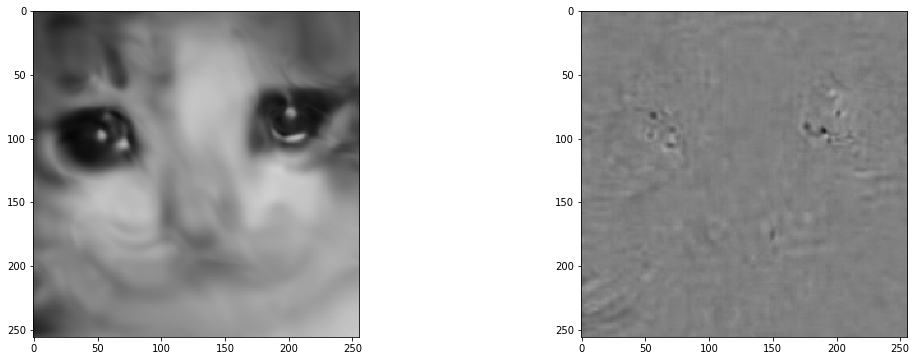

Step 13999, Current loss 0.001840


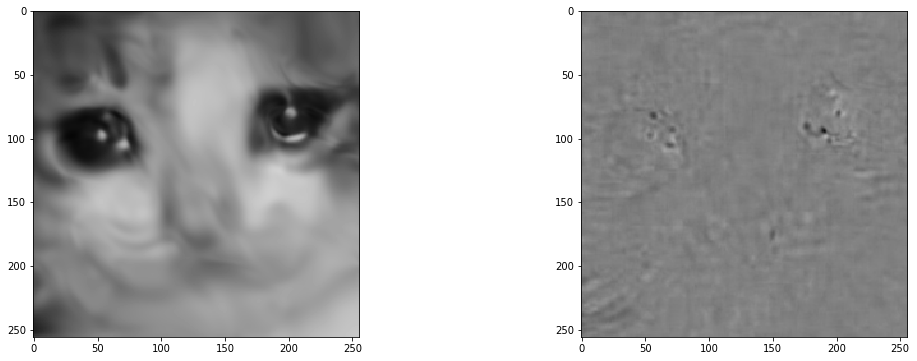

Step 14399, Current loss 0.001811


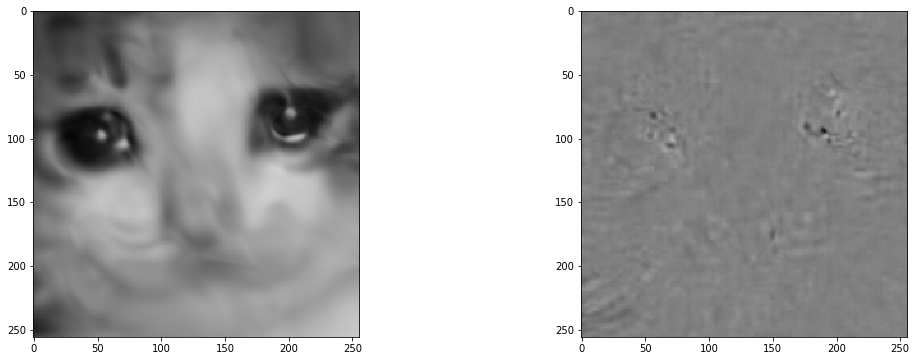

Step 14799, Current loss 0.001780


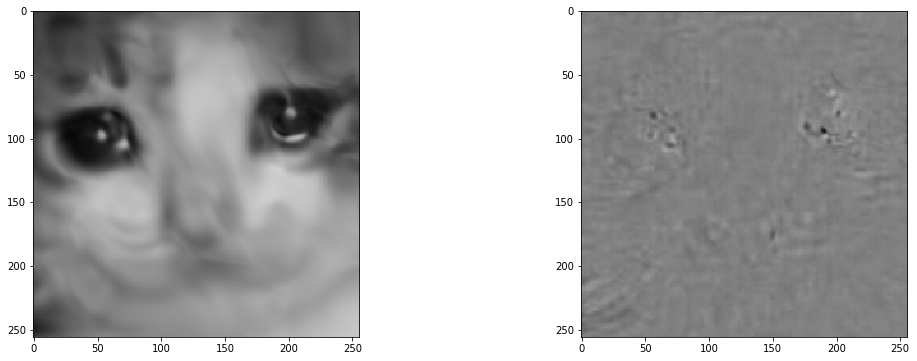

Step 15199, Current loss 0.001774


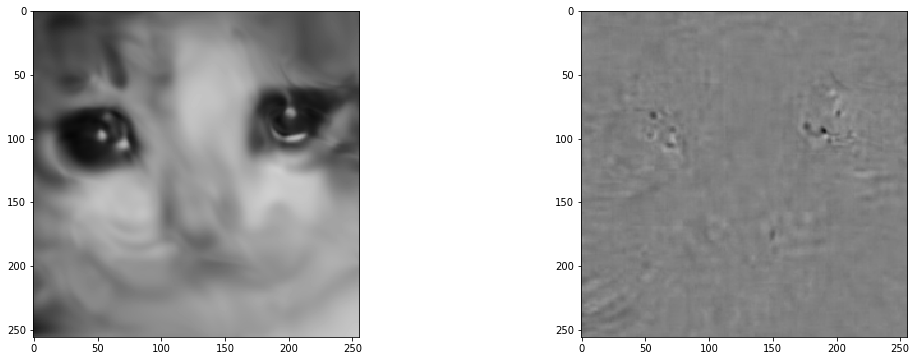

Step 15599, Current loss 0.001787


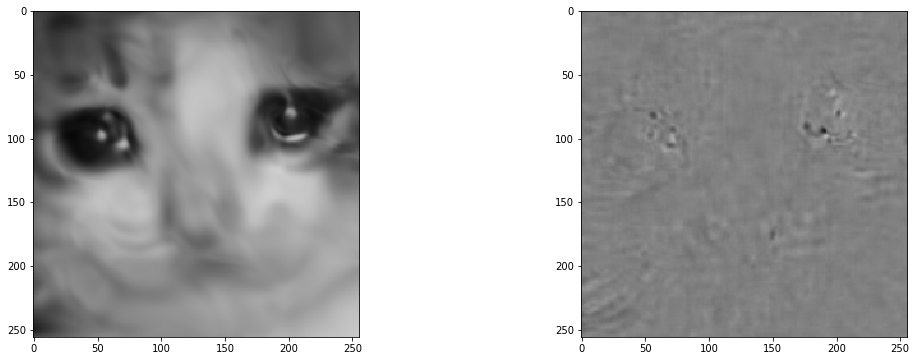

Step 15999, Current loss 0.001714


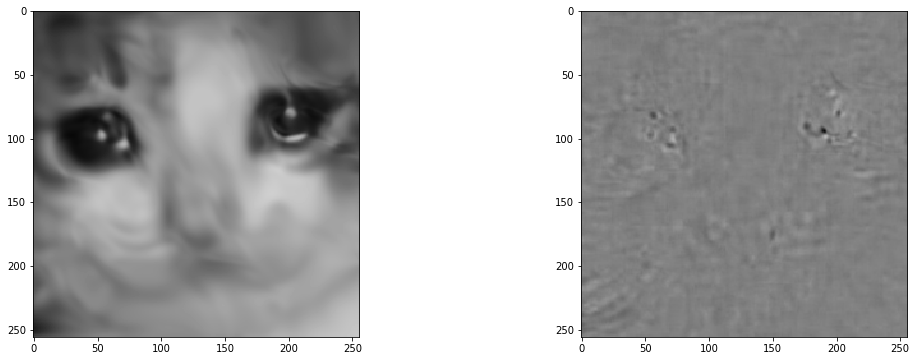

Step 16399, Current loss 0.001712


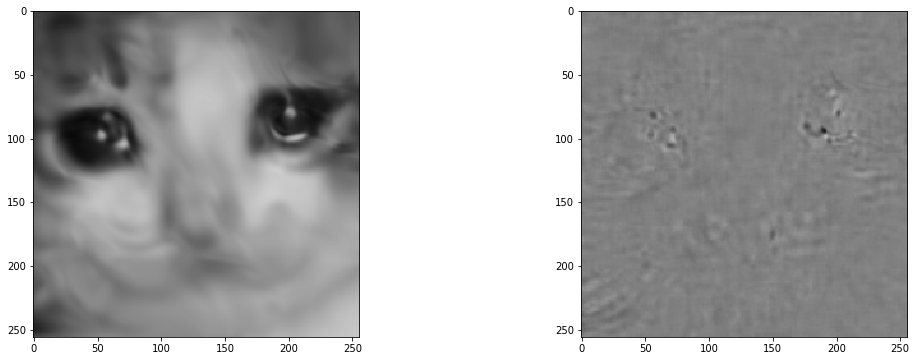

Step 16799, Current loss 0.001749


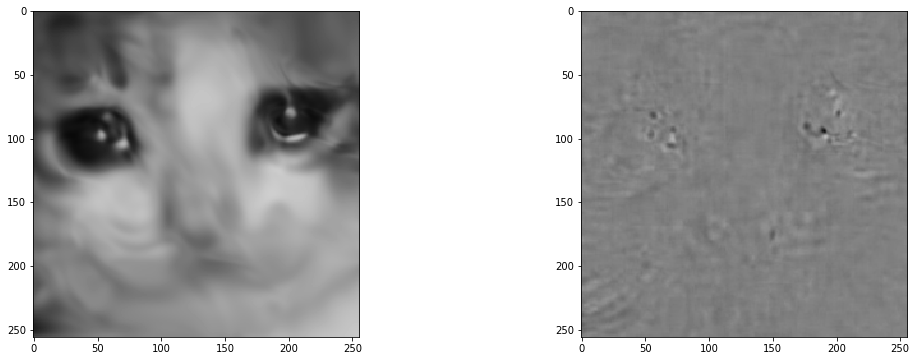

Step 17199, Current loss 0.001660


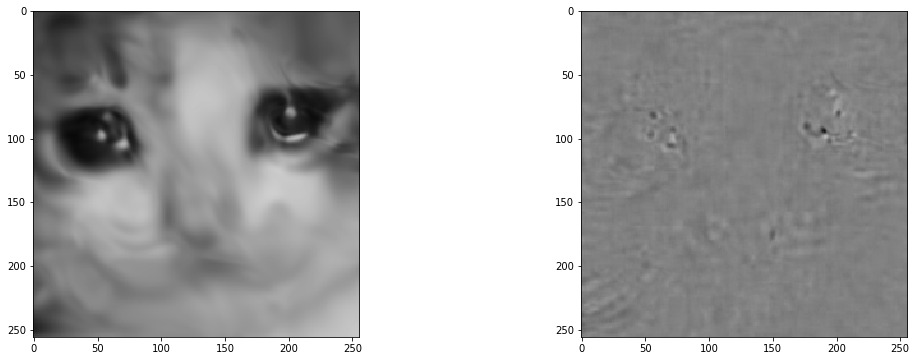

Step 17599, Current loss 0.001647


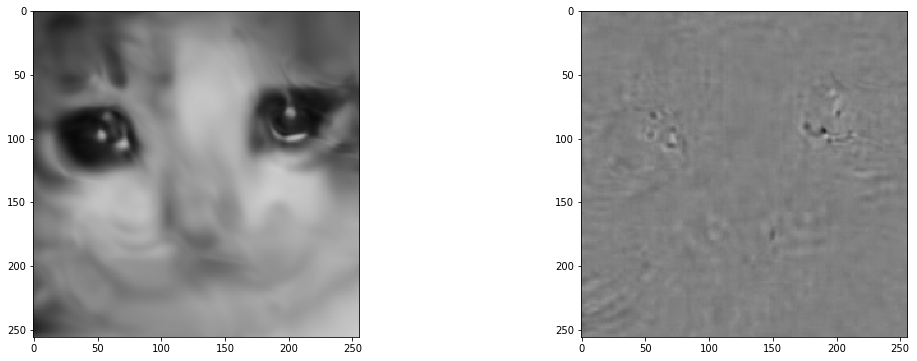

Step 17999, Current loss 0.001638


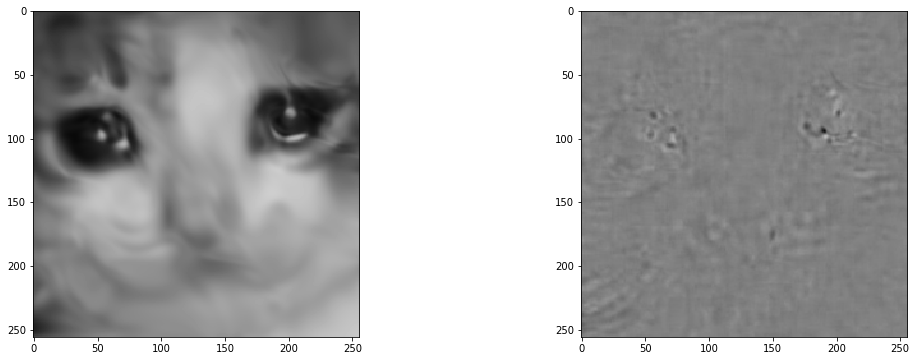

Step 18399, Current loss 0.001671


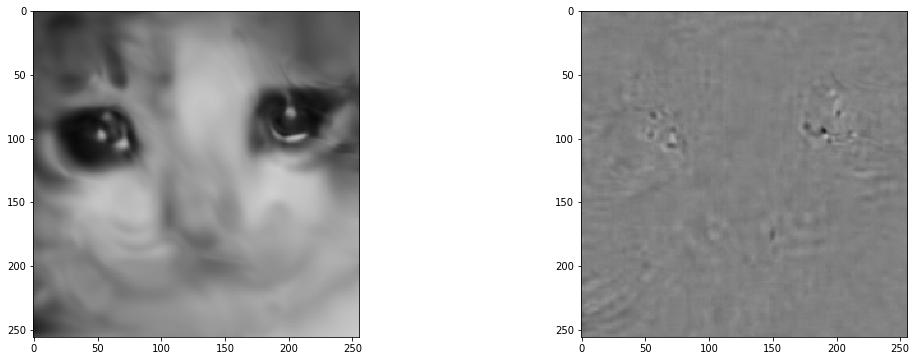

Step 18799, Current loss 0.001661


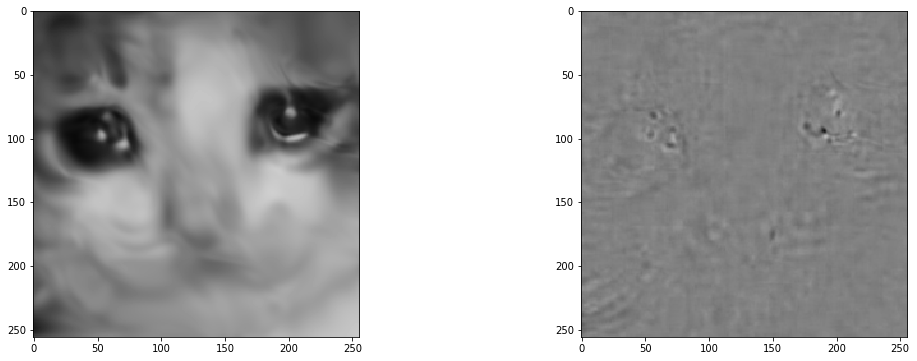

Step 19199, Current loss 0.001639


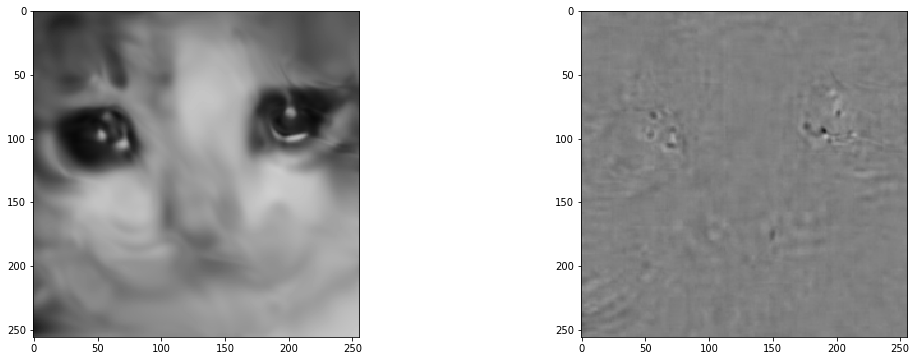

Step 19599, Current loss 0.001651


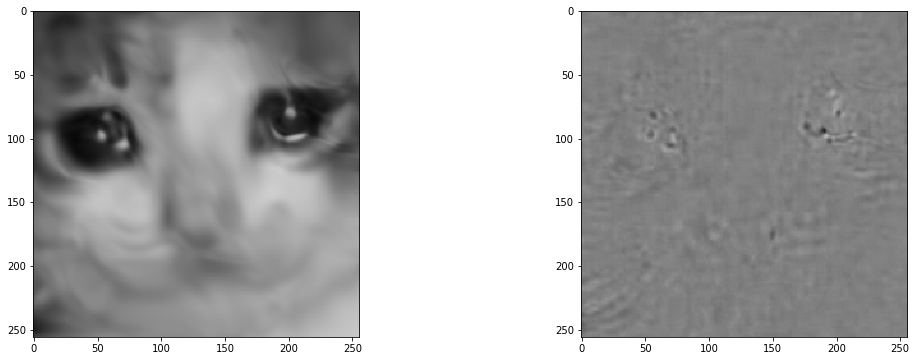

Step 19999, Current loss 0.001656


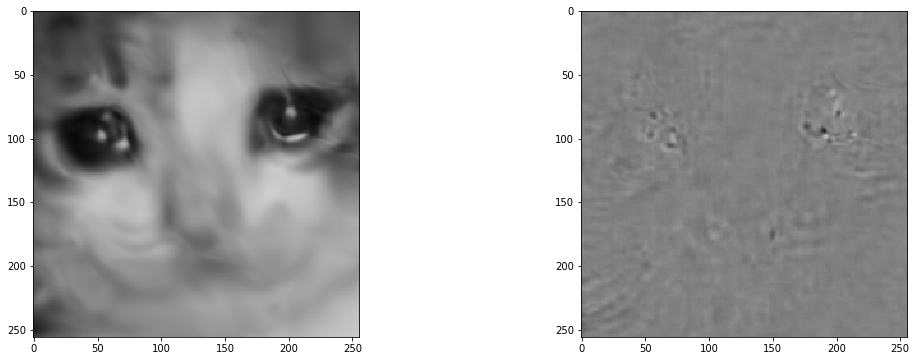

vec4 f1_0, f0_0=sin(ft_0*vec4(-2.33,-.20,-1.13,-.70)+ft_1*vec4(-.43,-1.26,2.45,-2.59)+vec4(1.09,5.46,-.07,4.82));
vec4 f1_1, f0_1=sin(ft_0*vec4(-3.16,2.69,-2.41,1.74)+ft_1*vec4(1.04,-3.82,.26,-3.73)+vec4(-5.29,-1.64,-2.60,2.58));
f1_0=sin(mat4(-.21,.24,-1.18,1.81,-.09,-.61,.58,.48,-.02,-.35,-.55,-.77,-.03,-.48,-.29,-.29)*f0_0+
    mat4(.77,-.07,-.33,-.37,.00,.22,-.07,.78,-.74,.33,-1.08,-.21,.27,.86,.80,.69)*f0_1+
    vec4(1.78,-1.50,.86,2.11))/1.0+f0_0;
f1_1=sin(mat4(-.12,-1.31,-.26,-.36,-.91,.49,-.46,.91,.35,-.12,.30,.34,-.27,.33,1.08,-2.05)*f0_0+
    mat4(.84,.14,.68,.04,.31,-.08,-.08,-.13,.31,.02,-.84,-.27,-.04,.66,-.49,.35)*f0_1+
    vec4(-1.13,-.58,1.82,-2.20))/1.0+f0_1;
f0_0=sin(mat4(.06,.32,-.44,.12,-.08,.28,-.60,-1.71,.46,-.36,1.59,-.15,-.06,-.96,.52,-.13)*f1_0+
    mat4(.38,-.60,-.43,-.09,1.12,-.34,-.08,-.21,.93,-.61,.08,.67,-1.05,-.48,-.12,-.51)*f1_1+
    vec4(-2.50,-2.31,.03,2.40))/1.4+f1_0;
f0_1=sin(mat4(-.24,-1.18,.97,.21,.34,.21,.03,.16,-.43,.60,-.45,-.93,.08,-.00,-.61,-.

In [129]:
cat_siren = train_siren(catloader, focusloader, 1, 8, 8, 10)
serialize_to_shadertoy(cat_siren, "f")


And then we train a colour map for the cat (this will be passed into a colour gradient)

In [ ]:
color_siren = train_siren(colorloader, 4, 2, 8, 500)

In [ ]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(1024, 2)
    model_out, _ = cat_siren(out_of_range_coords.cuda())
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(model_out.cpu().view(1024,1024).numpy(), cmap='gray', vmin=-1, vmax=1)
    plt.show()